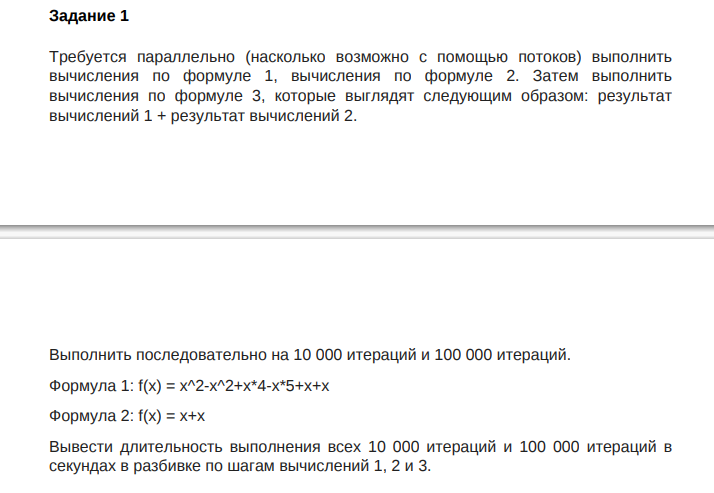

In [11]:
import threading
import math
import time
import datetime

data = {'f1':None, 'f2':None, 'f3':None}

def first_formula(x):
    t_start = datetime.datetime.now()
    thread_id = threading.get_ident()
    print(f"{t_start}: ПОТОК {thread_id} НАЧАЛО")
    
    for _ in range(int(10e3)):
        f = x**2 - x**2 + 4*x - 5*x + x + x
    t_end = datetime.datetime.now()
    
    print(f"{t_end}: ПОТОК {thread_id} КОНЕЦ")
    data['f1'] = t_end - t_start
        
def second_formula(x):
    t_start = datetime.datetime.now()
    thread_id = threading.get_ident()
    print(f"{t_start}: ПОТОК {thread_id} НАЧАЛО")
    
    for _ in range(int(10e4)):
        f = x + x
    t_end = datetime.datetime.now()
    
    print(f"{t_end}: ПОТОК {thread_id} КОНЕЦ")
    data['f2'] = t_end - t_start
    
def third_formula():
    t_start = datetime.datetime.now()
    thread_id = threading.get_ident()
    print(f"{t_start}: ПОТОК {thread_id} НАЧАЛО")
    while True:
        if data['f1'] is not None and  data['f2'] is not None:
            data['f3'] = data['f1'] + data['f2']
            f1, f2,f3 = data['f1'], data['f2'], data['f3']
            print('Время выполнения:')
            print(f'Первой формулы {f1}')
            print(f'Второй формулы {f2}')
            print(f'Третья формула {f3}')
            t_end = datetime.datetime.now()
            print(f"{t_end}: ПОТОК {thread_id} КОНЕЦ")
            break

t1 = threading.Thread(target=first_formula, kwargs={'x':5})
t2 = threading.Thread(target=second_formula, kwargs={'x':7})
t3 = threading.Thread(target=third_formula)

t3.start()
t1.start()
t2.start()

t3.join()
t1.join()
t2.join()



2024-10-19 01:37:50.244597: ПОТОК 31416 НАЧАЛО
2024-10-19 01:37:50.255594: ПОТОК 23640 НАЧАЛО
2024-10-19 01:37:50.257597: ПОТОК 23640 КОНЕЦ
2024-10-19 01:37:50.302595: ПОТОК 30844 НАЧАЛО
2024-10-19 01:37:50.306594: ПОТОК 30844 КОНЕЦ
Время выполнения:
Первой формулы 0:00:00.002003
Второй формулы 0:00:00.003999
Третья формула 0:00:00.006002
2024-10-19 01:37:50.306594: ПОТОК 31416 КОНЕЦ


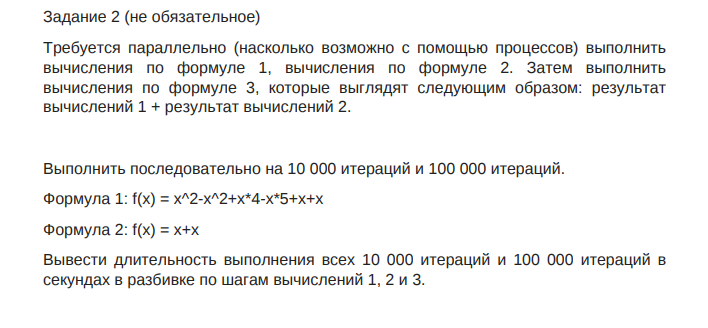

In [ ]:
from multiprocessing import Process, Pipe
from multiprocessing.connection import Connection
import os
import datetime

pid = os.getpid()

def first_formula_mp(conn: Connection, x: int) -> None:
    t_start = datetime.datetime.now()
    for _ in range(int(10e3)):
        f = x**2 - x**2 + 4*x - 5*x + x + x
    t_end = datetime.datetime.now()
    conn.send(t_end - t_start)
    conn.close()
    
def second_formula_mp(conn: Connection, x: int) -> None:
    t_start = datetime.datetime.now()
    for _ in range(int(10e4)):
        f = x + x
    t_end = datetime.datetime.now()
    conn.send(t_end - t_start)
    conn.close()
    
def third_formula_mp(conn: Connection, 
                     parent_conn1: Connection,
                     parent_conn2: Connection) -> None:
    data = {'f1':None, 'f2':None, 'f3':None}
    while True:
        try:
            data['f1'] = parent_conn1.recv()
        except:
            continue
        try:
            data['f2'] = parent_conn2.recv()
        except:
            continue
            
        if data['f1'] is not None and  data['f2'] is not None:
            data['f3'] = data['f1'] + data['f2']
            conn.send(data)
            conn.close()
            break
            
if __name__ == '__main__':
    parent_conn1, f1_conn = Pipe()
    parent_conn2, f2_conn = Pipe()
    parent_conn3, f3_conn = Pipe()
    
    f1 = Process(target=first_formula_mp, args=(f1_conn, 3))
    f2 = Process(target=second_formula_mp, args=(f2_conn, 4))    
    f3 = Process(target=third_formula_mp, args=(f3_conn, parent_conn1, parent_conn2))
    
    f1.start()
    f2.start()
    f3.start()
    f1.join()
    f2.join()
    f3.join()
    
    final_data = parent_conn3.recv()
    print(final_data)

{'f1': datetime.timedelta(microseconds=1998), 'f2': datetime.timedelta(microseconds=5000), 'f3': datetime.timedelta(microseconds=6998
)}